In [1]:
import scipy.io
import cv2 
import os
import matplotlib.pyplot as plt 
import numpy as np 

IMAGE_DIR = 'C:\\Users\\joo\\Desktop\\project\\datasets\\Caltech101\\101_ObjectCategories\\airplanes'
ANNOTATION_DIR = 'C:\\Users\\joo\\Desktop\\project\\datasets\\Caltech101\\Annotations\\Airplanes_Side_2'

# Load dataset 

In [2]:
image_file_list = os.listdir(IMAGE_DIR)
annotation_file_list = os.listdir(ANNOTATION_DIR)

# Check dataset and label (bounding box)

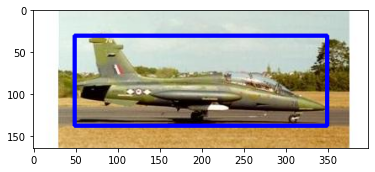

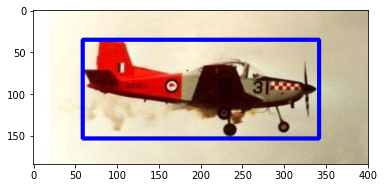

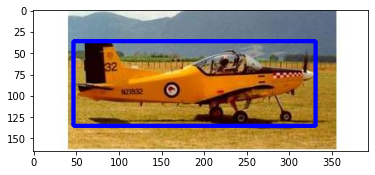

In [16]:

for ann_file, img_file in zip(annotation_file_list[:3], image_file_list[:3]):
    img_path = os.path.join(IMAGE_DIR, img_file)
    ann_path = os.path.join(ANNOTATION_DIR, ann_file)
    img = cv2.imread(img_path)

    ann = scipy.io.loadmat(ann_path)
    box = ann['box_coord'][0]

    left, top, right, bottom = box[2], box[0], box[3], box[1]

    cv2.rectangle(img, (left, top), (right, bottom), (255,0,0), 3)

    plt.imshow(img[:,:,::-1])
    plt.show()

# Convert datasets to tensor

In [4]:
x_data = np.zeros((800,224,224,3),dtype='float32')
y_data = np.zeros((800,4),dtype='float32')

count = 0
for ann_file, img_file in zip(annotation_file_list, image_file_list):
    img_path = os.path.join(IMAGE_DIR, img_file)
    ann_path = os.path.join(ANNOTATION_DIR, ann_file)
    img = cv2.imread(img_path)
    ann = scipy.io.loadmat(ann_path)
    box = ann['box_coord'][0]
    left, top, right, bottom = box[2], box[0], box[3], box[1]

    height, width = img.shape[:2]

    img = cv2.resize(img, dsize=(224, 224))
    left /= width
    top /= height
    right /= width
    bottom /= height

    x_data[count] = img.astype('float32')/255.0
    y_data[count] = np.array([left, top, right, bottom], dtype='float32')
    count += 1


# Split trian, validation, and test sets

In [5]:
x_train = x_data[:500]
y_train = y_data[:500]
x_val = x_data[500:600]
y_val = y_data[600:700]
x_test = x_data[700:]
y_test = y_data[700:]

# Make train model using VGG16

In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)
# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)


# fitting 

In [7]:
opt = Adam(lr=1e-4)
model.compile(loss="mse", optimizer=opt)
print(model.summary())
# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
H = model.fit(x_train, y_train,
	validation_data=(x_val, y_val),
	batch_size= 4,
	epochs=32,
    verbose=1)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

# Save model

In [8]:
model.save('model.h5')

# Draw train and validation losses for each epoch

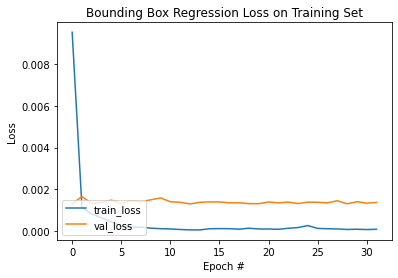

In [9]:
N = len(H.history['loss'])
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")


# Inference

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


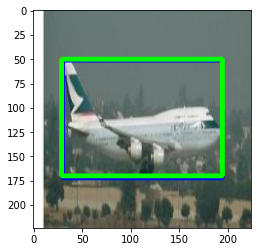

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


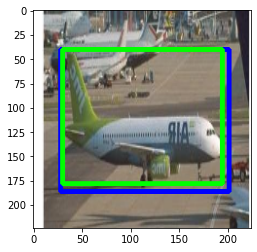

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


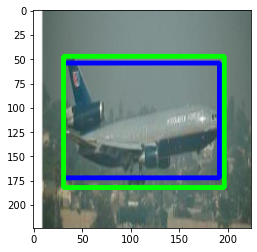

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


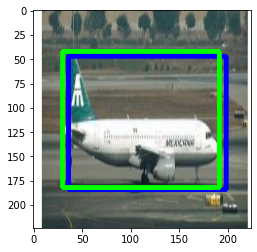

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


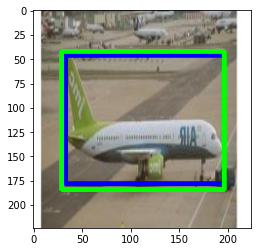

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


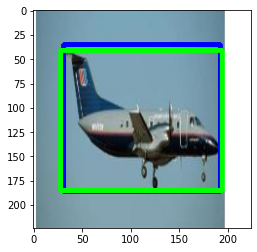

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


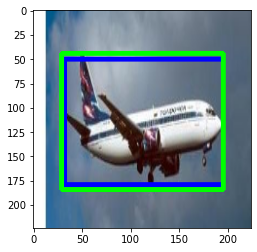

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


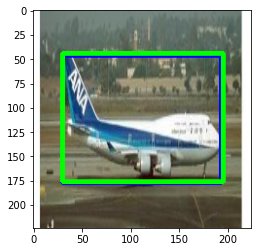

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


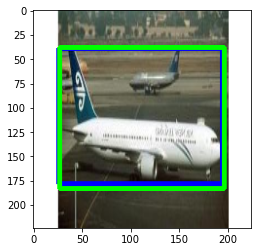

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


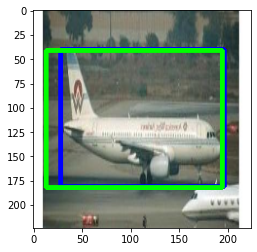

In [28]:
predict = model.predict(x_test)

import random

indexs = random.sample(range(len(x_test)), 10)
for index in indexs:
    img = x_test[index]
    gt = y_test[index]
    pr = predict[index]

    cv2.rectangle(img, (int(pr[0] * 224), int(pr[1] * 224)), (int(pr[2] * 224), int(pr[3] * 224)), (255,0,0), 3 )
    cv2.rectangle(img, (int(gt[0] * 224), int(gt[1] * 224)), (int(gt[2] * 224), int(gt[3] * 224)), (0,255,0), 3 )

    plt.imshow(img[:,:,::-1])
    plt.show()

